# **About this Project**
In this project, you will implement a simple Convolutional Neural Network that can recognize digits using PyTorch.

In [ ]:
%load_ext autoreload

In [ ]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [ ]:
%autoreload 2
# First off, import some packages
import torch
import torch.nn as nn
from torch.nn import functional as F

from torchvision import datasets, transforms
import torchvision

import matplotlib.pyplot as plt
from helper import *

import numpy as np
%matplotlib inline


# Seed the random number generator
torch.manual_seed(1)
torch.cuda.manual_seed(1)

# Check whether you have a gpu
# If you have a gpu, model training will be done on gpu
# which is significantly faster than training on cpu
gpu_available = torch.cuda.is_available()
print ("GPU is available:",gpu_available)

GPU is available: False


# **Convolutional Neural Network**
Part One: Loading the Dataset and Setting up Dataloader
We will be using a well-known public dataset called MNIST, which consists of 60,000 training and 10,000 test black and white images of handwritten digits with labels. The MNIST data has been widely used in the Machine Learning research community to develop image processing models.

Using Pytorch, we download the dataset locally, and wrap it up in a "dataloader". The models will iterate on batches in the dataloaders.

In [ ]:
# Setup the training set and test set
trainset = datasets.MNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.MNIST(root='.', train=False, download=True, transform=transforms.ToTensor())

# Setting up dataloader
# A dataloader stacks small batches of images (of 512 images in our case) into Tensors for easier training and evaluation
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, drop_last=True, batch_size=512, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, shuffle=True, drop_last=False, batch_size=512, num_workers=2)

100%|██████████| 9912422/9912422 [00:00<00:00, 86606682.70it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 19913807.96it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 23108894.85it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7476659.64it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
# Visualize the data
# The following line gets us small batch of data
# X is a tensor of size (512, 1, 28, 28) that contains a batch of images
# y is a tensor of size (512) that contains the labels in X
X, y = iter(trainloader).next()

def visualize_data(X):
    img_grid = torchvision.utils.make_grid(X[:5], padding=10)
    img_grid = img_grid.numpy()
    plt.imshow(np.transpose(img_grid, (1,2,0)), interpolation='nearest')
    return

visualize_data(X)

AttributeError: ignored

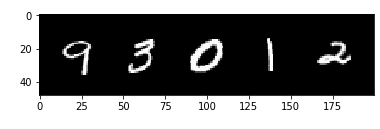

# **Part Two: Define a Convolutional Neural Network [Partially Graded]**
Define a Building Block of a CNN
A Convolutional Neural Network is made of multiple convolutional filters/kernels in a "block" that comprises the tunable weight parameters between a pair of layers. We create a class Block to hold all the parameters and define a forward function for forward propagation.

In [ ]:
class Block(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=3, stride=1):
        super(Block, self).__init__()

        self.in_channel = in_channel
        self.out_channel = out_channel
        self.kernel_size = kernel_size
        self.stride = stride

        # This block contains a convolutional layer
        # then a batch normalization layer

        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size, stride)
        self.bn = nn.BatchNorm2d(out_channel)
        return

    def forward(self, x):
        # passes the input image through a convolutional layer
        # followed by a batch normalization layer and relu transition
        out = F.relu(self.bn(self.conv(x)))
        return out

In [ ]:
# Create a block that is made up of 10 filters size 3x3 and stride 1

# The block takes in a image of 1 channel
Block1 = Block(1, 10, 3, 1)
out = Block1(X)

# After passing our image through block 1
# we get the following tensor
print(out.shape)

NameError: ignored

torch.Size([512, 10, 26, 26])

# **Build a CNN using the Block class [Graded]**
In this section, you will build a Convolutional Neural Network in ConvNet that consists of 4 CNN blocks, an average pooling layer and a fully connected layer in this order. We have created the first block for you. What you need to do is create the rest of the blocks based on the specification.

You can see that self.block1 is initialized with Block(). Below it are the specs for the other 3 blocks.

In other words, your solution should be 3 lines that initialize self.block2, self.block3, and self.block4 where it says # TODO. You need to pass in the appropriate parameters to Block(input_size, num_filters, kernel_size, stride). Note that the input_size of one layer is the num_filters of the previous layer.

Please do not change the name of the layers or else you risk breaking the autograder code!

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # First block takes in the image of channel 1
        # Filter specification:
            # Num filters=16, kernel size 3, stride 1
        self.block1 = Block(1, 16, 3, 1)

        # TODO
        # Second block takes in the output of the first block
        # Filter specification:
            # Num filters=32, kernel size 3, stride 1
        self.block2 = Block(16, 32, 3, 1)

        # TODO
        # Third block takes in the output of the 2nd block
        # Filter specification:
            # Num filters=64, kernel size 3, stride 1
        self.block3 = Block(32, 64, 3, 1)

        # TODO
        # Third block takes in the output of the 3rd block
        # Filter specification:
            # Num filters=128, kernel size 3, stride 1
        self.block4 = Block(64, 128, 3, 1)

        # This is the average pooling layer
        # This is applied to the output of the last convolutional layer
        # Essentially, it averages feature maps spatially to a single number
        # For instance, if the output of the last conv layer is of size (128, 15, 4, 4)
        # the following layer will average the 4x4 array into a single number
        # so the output of applying this layer would have size (128, 15, 1, 1)
        # This operation vectorize the feature maps so that we can have a vector
        # that can be passed into a simple linear layer for classification
        self.avgpool = nn.AdaptiveAvgPool2d(1)

        # Create a linear layer
        # the dataset has 10 classes
        # the model should output 10 belief values
        self.fc = nn.Linear(128, 10)

        # YOUR CODE HERE

        return

    def forward(self, x):
        batch_size = x.size(0)
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)

        # .squeeze() operation remove unnecessary dimension
        # i.e if X is of shape (128, 128, 1, 1)
        # X.unsqueeze() becomes (128, 128)
        out = self.avgpool(out).squeeze()
        out = self.fc(out)
        return out

In [ ]:
# Create a model
model = ConvNet()

# Move the model to a cuda gpu
# Doing this step allows up to do training on gpu
# and gain significant speed up
if gpu_available:
    model = model.cuda()

In [ ]:
def model_test1():

    model = ConvNet()

    if gpu_available:
        model = model.cuda()
    # check whether block2, 3, 4 are instances of block
    isblock2 = isinstance(model.block2, Block)
    isblock3 = isinstance(model.block3, Block)
    isblock4 = isinstance(model.block3, Block)
    return isblock2 and isblock3 and isblock4


def model_test2():
    model = ConvNet()

    if gpu_available:
        model = model.cuda()
    # Checking the specification for block 2

    # Check input channel
    in_channel_check = model.block2.in_channel == 16

    # Check the output channel
    out_channel_check = model.block2.out_channel == 32

    # Check the kernel size
    kernel_size_check = model.block2.kernel_size == 3

    # check the stride size
    stride_check = model.block2.stride == 1
    return in_channel_check and out_channel_check and kernel_size_check and stride_check

def model_test3():
    model = ConvNet()

    if gpu_available:
        model = model.cuda()
    # Checking the specification for block 3

    # Check input channel
    in_channel_check = model.block3.in_channel == 32

    # Check the output channel
    out_channel_check = model.block3.out_channel == 64

    # Check the kernel size
    kernel_size_check = model.block3.kernel_size == 3

    # check the stride size
    stride_check = model.block3.stride == 1
    return in_channel_check and out_channel_check and kernel_size_check and stride_check

def model_test4():
    model = ConvNet()

    if gpu_available:
        model = model.cuda()
    # Checking the specification for block 3

    # Check input channel
    in_channel_check = model.block4.in_channel == 64

    # Check the output channel
    out_channel_check = model.block4.out_channel == 128

    # Check the kernel size
    kernel_size_check = model.block4.kernel_size == 3

    # check the stride size
    stride_check = model.block4.stride == 1
    return in_channel_check and out_channel_check and kernel_size_check and stride_check


runtest(model_test1, 'model_test1')
runtest(model_test2, 'model_test2')
runtest(model_test3, 'model_test3')
runtest(model_test4, 'model_test4')

# **Part Three: Define a Loss Function and Optimizer [Graded]**
You are going to define the loss function and the optimizer. You should familiarize yourself with looking up PyTorch documentation.


# Loss function [Graded]
The loss function should be the cross entropy loss. You can also implement the loss function yourself but we strongly suggest you use PyTorch's implementation -- it should be one short call to a library loss function.

In [ ]:
#TODO: Define the loss function
loss_fn = nn.CrossEntropyLoss()

In [ ]:
def loss_fn_test1():
    num_classes = 10 # Suppose we have 10 classes
    num_examples = 5
    logits = torch.ones((num_examples, num_classes)) # Simulate model belief
    y=torch.zeros(num_examples).long();
    loss = loss_fn(logits, y) # calculate the loss

    # Check whether the loss is a scalar
    return loss.size() == torch.Size([])

def loss_fn_test2():
    num_classes = 10 # Suppose we have 10 classes

    # simulate model belief
    # in this case, the model believes that each class is equally likely
    logits = torch.ones((1, num_classes))
    y=torch.zeros(1).long();
    loss = loss_fn(logits,y) # calculate the loss

    # if the model has equal belief for each class, namely, P(y|x) is uniform
    # the negative loglikelihood should be -log(1 /num_classes) = log(num_classes)
    return (loss.item() == torch.log(torch.Tensor([num_classes])).item())

def loss_fn_test3():

    num_classes = 10 # Suppose we have 10 classes
    num_examples = 5

    # simulate model belief
    # in this case, the model believes that each class is equally likely
    logits = torch.rand((num_examples, num_classes))
    y=torch.zeros(num_examples).long();
    loss = loss_fn(logits, y)
    loss_grader = loss_fn_grader(logits, torch.zeros(num_examples).long())

    # Check whether your loss and our loss is almost the same
    return (torch.abs(loss - loss_grader)).item() < 1e-5


runtest(loss_fn_test1, 'loss_fn_test1')
runtest(loss_fn_test2, 'loss_fn_test2')
runtest(loss_fn_test3, 'loss_fn_test3')

# **Optimizer [Graded]**
I the next cell, you will define an SGD optimizer. Again, you should just call one library function from torch.optim. In addition to passing in the model parameters model.parameters(), please set lr=0.1.

In [ ]:
#TODO: Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# **Part Four: Train the Network [Graded]**
In this section, you are going to implement the train function. Please see the #TODOs in the code stub for specifications. Your solution should be one line for each todo (that is, 3 lines total).

logits is the output of a forward pass - to obtain them call model on the current mini-batch X.
loss should be calculated with the loss function loss_fn (HINT: look at the tests above to see how the loss function is called).
Finally, you need to back propagate by calling loss.backward() on the loss function.

In [ ]:
def train(model, optimizer, loss_fn, trainloader):
    """
    Trains the model using the optimizer, loss function, and training data in trainloader.

    Input:
        model: ConvNet model
        optimizer: optimizer for the model
        loss_fn: loss function
        trainloader: the dataloader

    Output:
        running_loss: the average loss of the network
    """

    # Set the model into train mode
    model.train()

    # Create a variable to keep track of the running loss
    running_loss = 0.0

    # iterate through trainloader
    # each iterate, you will get a batch of images X, and labels, y
    for i, (X, y) in enumerate(trainloader):

        if gpu_available:
            # Move the data to cuda gpu to accelerate training
            X, y = X.cuda(), y.cuda()

        # zero the parameter gradient
        optimizer.zero_grad()

        # TODO: Do a forward pass the get the logits
        logits = model(X)

        # TODO: Evaluate the loss
        loss = loss_fn(logits, y)

        # TODO: Do a backward pass by calling
        # .backward()
        loss.backward()

        # update the parameters
        optimizer.step()

        # update the loss
        running_loss += loss.item()

    return running_loss / len(trainloader)

In [ ]:
def train_test1():
    from copy import deepcopy


    model = ConvNet()
    if gpu_available:
        model = model.cuda()
    model2 = deepcopy(model)

    optimizer = create_optimizer(model)
    optimizer2 = create_optimizer(model2)

    # sample one batch of training examples
    X, y = iter(trainloader).next()

    # Create a dataset using the small batch
    small_set = torch.utils.data.TensorDataset(X, y)

    # create a dataloader for the small_set
    loader = torch.utils.data.DataLoader(small_set, batch_size=128)

    # run your train function twice
    # Essentially update the model twice
    loss = train(model, optimizer, loss_fn, loader)
    loss2 = train(model, optimizer, loss_fn, loader)

    # run our train function twice
    # update the model twice
    loss_grader = train_grader(model2, optimizer2, loss_fn, loader)
    loss_grader_2 = train_grader(model2, optimizer2, loss_fn, loader)

    # your losses and our losses should be too different
    return ((loss - loss_grader)**2 + (loss2 - loss_grader_2)**2) < 1e-5

runtest(train_test1, 'train_test1')

In [ ]:
# The following code will train the model
# Running this cell should take about three minutes. A progress ber will display speed and duration of training.

num_epochs = 10
all_running_losses = []

for epoch in tqdm(range(num_epochs)):
    running_loss = train(model, optimizer, loss_fn, trainloader)
    print('Running Loss for Epoch [{}/ {}]: {:.4f}'.format(epoch + 1, num_epochs, running_loss))
    all_running_losses.append(running_loss)

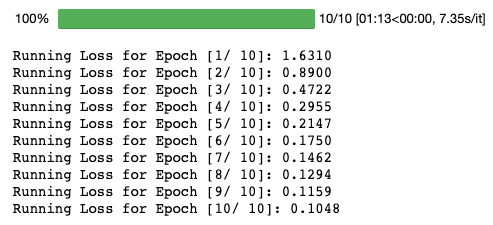

In [ ]:
# Plotting
plt.plot(range(1, num_epochs + 1), all_running_losses, label='Running Loss')
plt.xlabel('Epoch')
plt.ylabel('Running Loss')
plt.show()

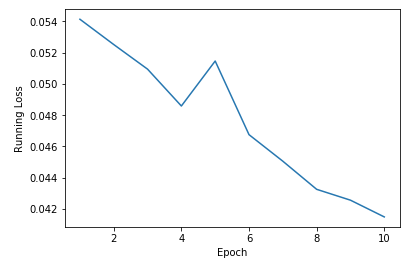

# **Part Five: Test the network on the test data [Graded]**
In this section, you will implement pred that takes in the output of the forward pass (the logits) and outputs its prediction. logits is a matrix of shape (n, C) where C is the number of labels (10 for MNIST -- number of digits). The prediction should be the argmax along the second axis (dim=1).

In [ ]:
def pred(logits):
    """
    Calculates the predictions of the ConvNet using the logits.

    Input:
        logits: nxC output matrix of the network. n is the number of data points, C is the number of labels.

    Output:
        prediction: n-dimensional vector of predictions
    """

    # TODO Calculate the prediction based using torch.argmax

    prediction = torch.argmax(logits, dim=1)

    return prediction

In [ ]:
def pred_test1():

    # Generate some beliefs
    logits = torch.Tensor([[0, 1], [2, -1]])
    prediction = pred(logits)

    # the expected output should be [1, 0]
    expected_output = torch.LongTensor([1, 0])

    return torch.equal(prediction, expected_output)

runtest(pred_test1, 'pred_test1')

We trained the model above and now we can evaluate it using your pred function.

In [ ]:
# the following code will use your pred function and evaluate the whole test set and print your model's accuracy

total = 0.0
correct = 0.0
model.eval()
with torch.no_grad():
    for X, y in testloader:
        if gpu_available:
            X, y = X.cuda(), y.cuda()
        logits = model(X)

        prediction = pred(logits)
        total += X.size(0)
        correct += (prediction == y).sum().item()

print('Accuracy of the model: {:.4}%'.format(correct / total * 100))

Accuracy of the model: 98.24%

In [ ]:
# Visualize some of the test images
# and see their prediction

test_iterator = iter(testloader)
X_test, y_test = test_iterator.next()
X_test, y_test = X_test[:5], y_test[:5]
visualize_data(X_test)
model.eval()
with torch.no_grad():
    if gpu_available:
        X_test = X_test.cuda()
    logits = model(X_test)
    prediction = pred(logits)
print("Prediction: ", prediction.tolist())

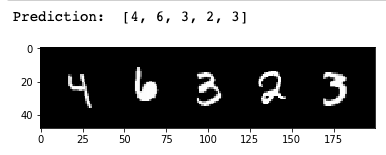

# **Tensorflow approach**
We can train the same network on MNIST data in Tensorflow as well.

In [ ]:
import tensorflow as tf
import math

In [ ]:
def plot_imgs(images, labels=None):
    subplots_x = int(math.ceil(len(images) / 5))
    plt.figure(figsize=(10,2*subplots_x))
    for i in range(min(len(images), subplots_x*5)):
        plt.subplot(subplots_x,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        if labels is not None:
            plt.xlabel(labels[i])
    plt.show()

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
plot_imgs(x_train[:5], y_train[:5])

11490434/11490434 [==============================] - 0s 0us/step


NameError: ignored

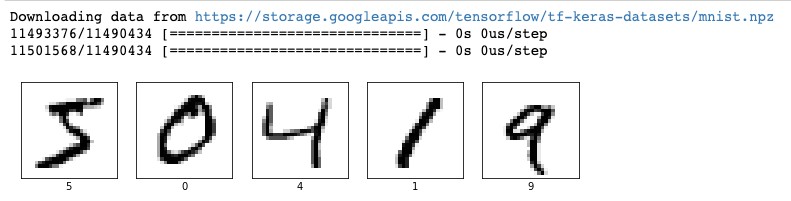

In [ ]:
# Tensorflow downloads the images raw. We must normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Converting datasets of shape (num_points, 28, 28) to (num_points, 28, 28, 1)
x_train, x_test = x_train[..., np.newaxis], x_test[..., np.newaxis]

NameError: ignored

In [ ]:
def block_tf(filters, kernel_size, stride):
    return [
        tf.keras.layers.Conv2D(filters, kernel_size, strides=(stride, stride), activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU()
    ]

## Define the network
model = tf.keras.models.Sequential([tf.keras.Input((28, 28, 1))] \
    + block_tf(16, 3, 1) \
    + block_tf(32, 3, 1) \
    + block_tf(64, 3, 1) \
    + block_tf(128, 3, 1) + [
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10, activation=None)
])

model.summary()

## Define the loss function and optimizer
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10)

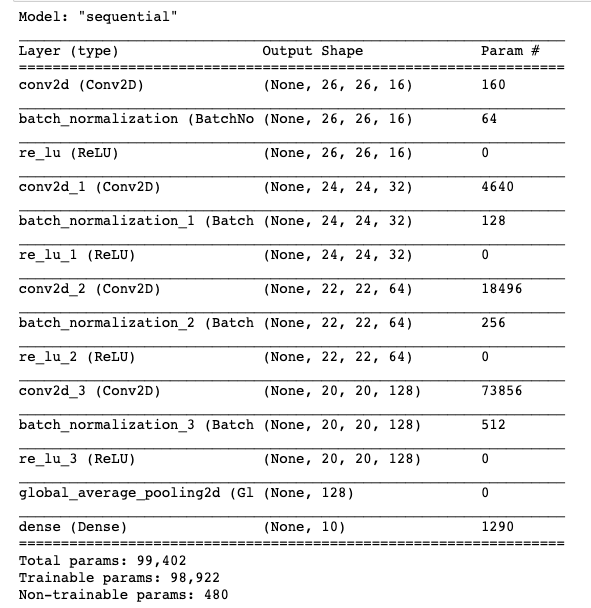

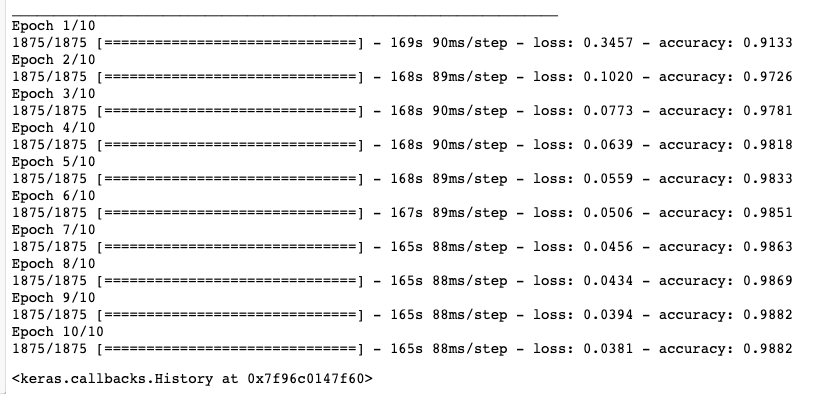

In [ ]:
## Evaluate the network
logits = model(x_test)
predictions = tf.argmax(logits, axis=1)
print('Accuracy of the model: {:.4f}%'.format(tf.reduce_mean(tf.cast(predictions == y_test, tf.float32)).numpy() * 100))

print('Predictions on first 5 test images:')
plot_imgs(np.squeeze(x_test * 255, axis=-1)[:5], predictions.numpy()[:5])

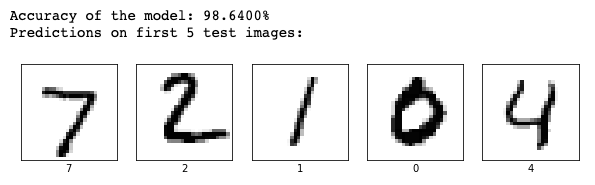

# **Visualizing activations using Grad-CAM**
With the Grad-CAM algorithm, we can also visualize the pixels that "trigger" activations in the convolutional layers of the network. Here's an example where the algorithm returns a heatmap of activations in the last convolutional layer triggered by the image. We superimpose the heatmap on the image, but they might not align together exactly. "Hot" (yellow-red) regions in the heatmap indicate the pixels that triggered high magnitude activations, whereas "cold" (dark blue) regions indicate the pixels that did not significantly trigger activations.

Note: the heatmap might be shifted by a few pixels.

Play around with different images and check out the activated regions. Do you think the network is triggered by regions of images that we, as humans, consider the defining features for the corresponding classes? (For example, is the network triggered by the circle of the 0 image?)

In [ ]:
img_idx =17

img_array = x_test[img_idx][np.newaxis, ...]

logits = model(img_array)
predictions = tf.argmax(logits, axis=1)

last_conv_layer_name = [layer.name for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)][-1]
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
display_gradcam(np.uint(255 * img_array)[0], heatmap, prediction=int(predictions.numpy()[0]))

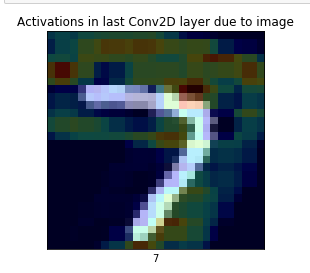